## GROCERY CLASSIFER
A trained CNN that, through image recognition, will output the highest probable type of fruit or vegetable when fed with an image. A dataset of 90480 images (that can be found in this <a href="https://www.kaggle.com/datasets/moltean/fruits">link</a>) are being used to train the model.

In [23]:
# library imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import torch
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
print(tf.config.list_physical_devices())
print(torch.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0.dev20231221


### Dataset
In this section we'll be handling the dataset and creating datasets along with data loaders.

In [24]:
data_dir = "fruits-360/"
train_dir = data_dir+"train/"
test_dir = data_dir+"test/"

In [25]:
# creating a transform object for training
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(100),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))
])

# creating a dataset from folder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# creating train loader from dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# creating a transform object for testing
test_transform = transforms.Compose([
    transforms.Resize(100),
    # transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))
])

# creating a dataset from folder
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# creating train loader from dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

<class 'torch.Tensor'>
torch.Size([3, 100, 100])


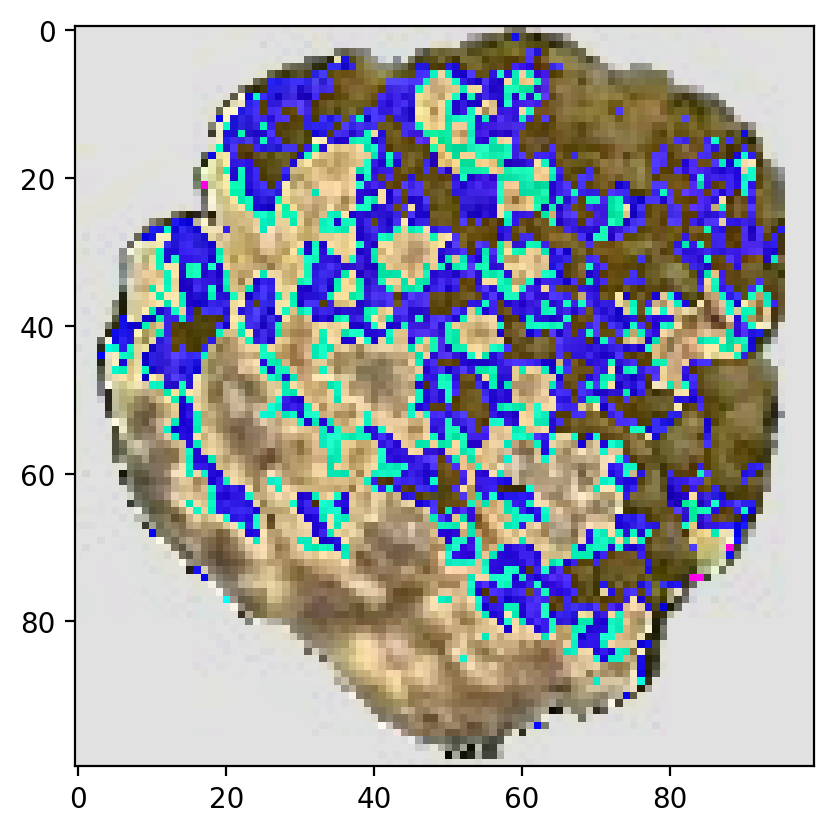

In [26]:
# checking image size
images, labels = next(iter(test_loader))
print(type(images[0]))
print(images[0].shape)

img = images[0].permute(1,2,0)
img = img.numpy()
img = (img * 225).astype(np.uint8)
img = Image.fromarray(img, 'RGB')
plt.imshow(img);

### Label Mapping
In this secion we need to have a list of classes poiting to their respective names.

In [27]:
fruit_names = {}
idx = 1
for label in os.listdir(train_dir):
    # print(f'label: {label}, isDir: {os.path.isdir(label)}')
    fruit_names[idx] = label
    idx += 1
fruit_names

{1: 'Tomato 4',
 2: 'Apple Red Delicious',
 3: 'Tomato 3',
 4: 'Huckleberry',
 5: 'Blueberry',
 6: 'Pear Red',
 7: 'Banana Lady Finger',
 8: 'Melon Piel de Sapo',
 9: 'Pear',
 10: 'Cherry 1',
 11: 'Strawberry',
 12: 'Nut Forest',
 13: 'Avocado',
 14: 'Tomato 2',
 15: 'Pomegranate',
 16: 'Dates',
 17: 'Carambula',
 18: 'Potato Red Washed',
 19: 'Granadilla',
 20: 'Kohlrabi',
 21: 'Tamarillo',
 22: 'Pepper Red',
 23: 'Fig',
 24: 'Ginger Root',
 25: 'Kiwi',
 26: 'Cherry Wax Yellow',
 27: 'Lemon',
 28: 'Guava',
 29: 'Apple Golden 2',
 30: 'Pear Stone',
 31: 'Apple Red 1',
 32: 'Cauliflower',
 33: 'Mandarine',
 34: 'Quince',
 35: 'Strawberry Wedge',
 36: 'Pear Monster',
 37: 'Raspberry',
 38: 'Pitahaya Red',
 39: 'Nut Pecan',
 40: 'Apple Golden 3',
 41: 'Redcurrant',
 42: 'Apple Red Yellow 1',
 43: 'Pepper Yellow',
 44: 'Grape Pink',
 45: 'Banana Red',
 46: 'Cucumber Ripe 2',
 47: 'Physalis',
 48: 'Cherry Rainier',
 49: 'Maracuja',
 50: 'Chestnut',
 51: 'Plum',
 52: 'Potato Sweet',
 53: 'Cu

### CNN
Now we need to create a network in order to train the model using the dataset

In [28]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        # self.relu2 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        # self.relu3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # self.conv4 = nn.Conv2d(128,256,5,padding=1)
        # self.relu4 = nn.ReLU()
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # self.conv5 = nn.Conv2d(256,512,5,padding=1)
        # self.relu5 = nn.ReLU()
        # self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(9216,4608)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(4608,576)
        # self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(576, 131)
        
    
    def forward(self,x):
        # forward pass through conv1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # forward pass through conv3
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # forward pass through conv3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        # forward pass through conv4
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x,2)

        # forward pass through conv5
        # x = self.conv5(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x,2)

        # flattenig output from previous conv layer
        # x = torch.flatten(x, 1)
        x = x.view(x.size(0), -1)
        
        # forward pass through hidden layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # forward pass through hidden layer 1
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        
        # forward pass through output layer
        x = self.fc3(x)

        # pass output to softmax to get predictions
        output = F.log_softmax(x, dim=1)
        
        return output

### Training Network
The next step is to train the network using the chosen architecture.

In [ ]:
model = Model()

epochs = 5
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

running_loss = 0
train_losses = []
test_losses = []

# setting up gpu in tensorflow
with tf.device('/GPU:0'):
    for e in range(epochs):
        # training network
        model.train()
        for images, labels in train_loader:
            # zeroing out gradients
            optimizer.zero_grad()
            
            # forward pass
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()

            # backwards and optmizing
            loss.backward()
            optimizer.step()

        else:
            # validating network
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    # forward pass
                    test_ps = model(images)
                    
                    t_loss = criterion(test_ps, labels)
                    test_loss += t_loss.item()
                    
                    # calculate accuracy
                    ps = torch.exp(test_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print(f'epoch: {e+1}/{epochs}; '
                  f'running loss: {running_loss/len(train_loader):.3f}; '
                  f'test loss: {test_loss/len(test_loader):.3f}; '
                  f'accuracy: {accuracy/len(test_loader):.3f}; ')
            
            # resetting running loss
            running_loss = 0

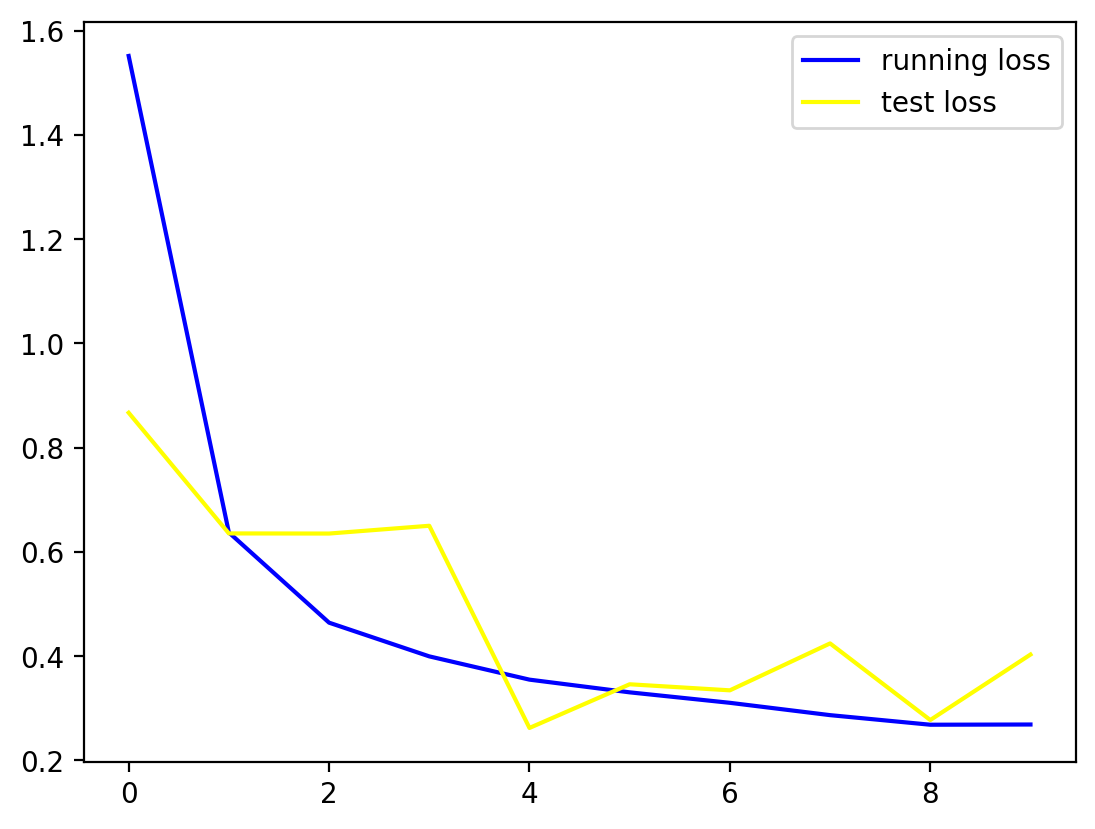

In [8]:
# plotting loss difference
fig, ax = plt.subplots()
ax.plot(train_losses, color = 'blue', label = 'running loss')
ax.plot(test_losses, color = 'yellow', label = 'test loss')
ax.legend()
plt.show()

In [ ]:
# test the model using a random image
def predict(image):
    with torch.no_grad():
        # print(fruit_names)
        outputs = model(img_tensor)
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(5, dim=1)

        prob = top_p.cpu().numpy().tolist()
        predicted_classes = top_class.cpu().numpy().tolist()
        
    return prob, predicted_classes
        
original_image = Image.open(train_dir+'Banana/0_100.jpg')
img_tensor = test_transform(original_image)
# print(type(img_tensor))
# print(img_tensor.shape)

processed_image = img_tensor.permute(1,2,0)
processed_image = processed_image.numpy()
processed_image = (processed_image * 225).astype(np.uint8)
processed_image = Image.fromarray(processed_image, 'RGB')
# plt.imshow(processed_image);

prob, pred = predict(processed_image)
print(prob)
print(pred)

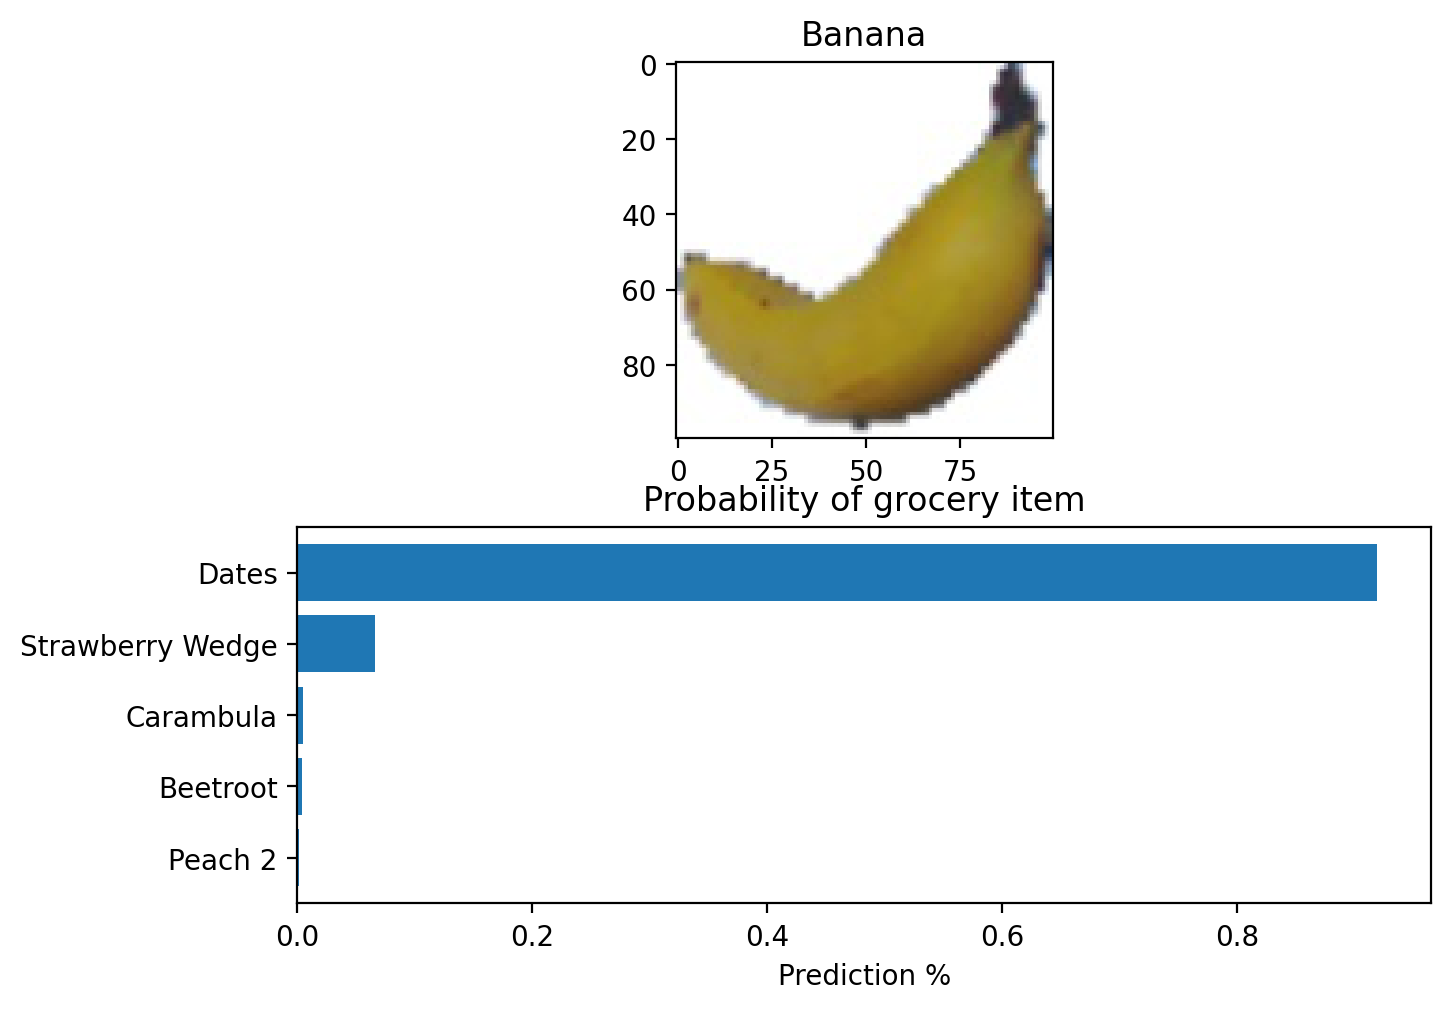

In [15]:
# plot image and chart of top k predicted values
fig, axs = plt.subplots(2)
fig.tight_layout()

axs[0].set_title('Banana')
axs[0].imshow(original_image)

# print(prob[0])
# print(pred[0])

labels = [fruit_names[idx] for idx in pred[0]]

y_pos = np.arange(len(labels))

axs[1].barh(labels, prob[0])
axs[1].set_yticks(y_pos,labels=labels)
axs[1].invert_yaxis()
axs[1].set_xlabel('Prediction %')
axs[1].set_title('Probability of grocery item')
axs[1].plot();